In [2]:
import requests
from bs4 import BeautifulSoup
import datetime
import locale
locale.setlocale(locale.LC_ALL, 'ID')
import re
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import time
from requests.exceptions import ConnectionError
import unicodedata
import mysql.connector
import pandas as pd

import nltk
from nltk import word_tokenize
from nltk.util import ngrams
from collections import Counter
import nltk.data
import nltk.tokenize

In [3]:
df = pd.read_csv("article_201809061411.csv")

In [3]:
df.shape

(351418, 14)

In [4]:
df.source.nunique()

29

In [5]:
a = pd.DataFrame(df.groupby('source')['id'].count()).sort_values(by='id', ascending=False).reset_index()

In [6]:
b = pd.DataFrame(df.groupby('source')['pubdate'].max()).reset_index()

In [10]:
a.merge(b, left_on='source', right_on='source', how='inner')

source     id              pubdate
0            antara  45947  2018-08-31 23:56:21
1         Sindonews  37335  2018-08-28 23:59:00
2          Liputan6  32470  2018-08-27 23:03:20
3             detik  31390  2018-08-31 23:02:06
4       metrotvnews  29374  2018-09-06 10:14:10
5           okezone  27514  2018-08-31 23:45:24
6           gridoto  24851  2018-08-31 23:59:13
7             tempo  18477  2018-08-31 23:38:33
8            otosia  15047  2018-08-09 18:15:00
9          tirto.id  13854  2018-08-29 00:00:00
10         mobil123  11956  2018-08-30 16:00:00
11         idntimes   9890  2018-08-31 00:00:00
12        otodriver   7716  2018-09-01 08:00:00
13         rumah123   7565  2018-08-21 20:00:34
14              oto   6402  2018-08-30 11:41:40
15        rajamobil   6037  2018-08-10 12:56:47
16          rumahku   5272  2018-05-14 08:51:00
17         otorider   4942  2018-09-01 07:55:00
18          carmudi   3738  2018-08-31 19:11:45
19        carreview   3008  2018-08-31 17:05:00
20       rumahhokie   2117  2018-08-31 18:29:55
21       cintamobil   2098  2018-09-01 00:00:00
22      otomart.com   1925  2018-08-30 13:35:54
23    housingestate    761  2018-08-31 18:22:03
24           kompas    555  2018-08-08 23:55:12
25  propertiterkini    375  2018-08-21 06:48:22
26             seva    367  2018-08-31 09:58:57
27             viva    278  2018-01-12 23:48:28
28       tribunnews    157  2018-01-10 23:59:34

### Missing Value

In [19]:
# total = pd.DataFrame(df.groupby('source')['id'].count()).sort_values(by='id', ascending=False)
# total

In [11]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'missing_values', 1 : 'percent'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        'percent', ascending=False).round(2)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [12]:
missing_values_table(df)

Your selected dataframe has 14 columns.
There are 7 columns that have missing values.


missing_values  percent
title                 31193     8.88
tags                  25921     7.38
author                14484     4.12
subcategory           14371     4.09
images                12994     3.70
content                 168     0.05
category                  7     0.00

In [13]:
title = pd.DataFrame(df[df['title'].isnull()].groupby('source')['id'].count())
title['percen'] = round((100* title['id']/len(df)),2)
title

id  percen
source               
detik   31193    8.88

In [14]:
tags = pd.DataFrame(df[df['tags'].isnull()].groupby('source')['id'].count()).sort_values(by='id',ascending=False)
tags['percen'] = round((100* tags['id']/len(df)),2)
tags.head()

id  percen
source                  
rumah123    7565    2.15
rajamobil   6037    1.72
rumahku     5272    1.50
detik       2529    0.72
rumahhokie  2117    0.60

In [15]:
images = pd.DataFrame(df[df['images'].isnull()].groupby('source')['id'].count()).sort_values(by='id',ascending=False)
images['percen'] = round((100* images['id']/len(df)),2)
images.head()

id  percen
source                    
detik        11229    3.20
Liputan6      1430    0.41
otomart.com     95    0.03
rajamobil       88    0.03
Sindonews       72    0.02

In [16]:
author = pd.DataFrame(df[df['author'].isnull()].groupby('source')['id'].count()).sort_values(by='id',ascending=False)
author['percen'] = round((100* author['id']/len(df)),2)
author.head()

id  percen
source                  
rumah123    7565    2.15
rumahku     3439    0.98
otosia      2254    0.64
cintamobil   647    0.18
okezone      184    0.05

In [25]:
content = pd.DataFrame(df[df['content']==''].groupby('source')['id'].count()).sort_values(by='id',ascending=False)
content['percen'] = round((100* content['id']/len(df)),2)
content.head()
# df[df['content'].isnull()].groupby('source')['id'].count()

id  percen
source               
antara     70    0.02
tempo      60    0.02
rajamobil  32    0.01
tirto.id    4    0.00
carmudi     1    0.00

In [26]:
category = pd.DataFrame(df[df['category']== ''].groupby('source')['id'].count()).sort_values(by='id',ascending=False)
category['percen'] = round((100* category['id']/len(df)),2)
category

id  percen
source            
tempo    7     0.0

In [18]:
df['category'] = df['category'].fillna('')
df['content'] = df['content'].fillna('')
df['subcategory'] = df['subcategory'].fillna('')


In [21]:
df['category'] = df['category'].values.astype('str')

In [27]:
sub = pd.DataFrame(df[df['subcategory'].isnull()].groupby('source')['id'].count()).sort_values(by='id',ascending=False)
sub['percen'] = round((100* sub['id']/len(df)),2)
sub.head()

id  percen
source                   
tirto.id    13854    3.94
oto           398    0.11
antara         50    0.01
detik          36    0.01
tribunnews     12    0.00

In [3]:
import numpy as np

In [28]:
df['content'] = df['content'].fillna('')

In [29]:
df.iloc[2161]

id                                                          2162
post_id                                                   216577
author                                                     Putri
pubdate                                      2018-01-02 21:17:10
category                                                Otomotif
subcategory                                                 News
content                                                         
comments                                                       0
images         https://assets.gridoto.com/crop/0x0:700x467/70...
title                   Wow! Yamaha Produksi Motor Khusus Lansia
tags                                         Yamaha,motor lansia
url            https://www.gridoto.com/read/01216577/wow-yama...
source                                                   gridoto
is_popular                                                     0
Name: 2161, dtype: object

## Tokenized Text for Every Row

In [30]:
list_corpus = []

In [32]:
# df['content'].apply(lambda x: list_corpus.append(x))

In [33]:
len(list_corpus)

241868

In [34]:
corpus = ' '.join(list_corpus)

In [35]:
tokens = nltk.word_tokenize(corpus.lower())

In [36]:
len(tokens)

73189683

In [37]:
tokens[:4]

['membeli', 'hunian', 'atau', 'tempat']

In [38]:
fdist = nltk.FreqDist(ch for ch in tokens if ch.isalpha())

In [39]:
freq1 = fdist.most_common(50)
# freq1['percen'] = round((100 * freq1[1] / len(tokens)),2)
freq1

[('yang', 1566774),
 ('di', 1263133),
 ('dan', 1193763),
 ('ini', 727588),
 ('dengan', 700246),
 ('untuk', 614368),
 ('dari', 520766),
 ('itu', 441091),
 ('pada', 408063),
 ('juga', 390874),
 ('akan', 372293),
 ('dalam', 354887),
 ('tidak', 315182),
 ('ada', 258001),
 ('bisa', 257824),
 ('ke', 238606),
 ('tersebut', 235670),
 ('indonesia', 231255),
 ('lebih', 215295),
 ('sudah', 206145),
 ('tahun', 206043),
 ('saat', 197343),
 ('menjadi', 194292),
 ('mobil', 190329),
 ('jakarta', 180250),
 ('kami', 178695),
 ('karena', 178575),
 ('atau', 174796),
 ('oleh', 159995),
 ('sebagai', 151359),
 ('kata', 148959),
 ('adalah', 146932),
 ('saya', 144241),
 ('satu', 143261),
 ('mereka', 140518),
 ('seperti', 136948),
 ('dia', 127052),
 ('telah', 125274),
 ('baru', 124733),
 ('masih', 121605),
 ('hanya', 120502),
 ('motor', 116257),
 ('kita', 112770),
 ('memiliki', 107653),
 ('hingga', 106204),
 ('dapat', 106115),
 ('tak', 104713),
 ('banyak', 104450),
 ('harus', 104319),
 ('para', 103130)]

In [85]:
fdist_sym = nltk.FreqDist(ch for ch in tokens if (not ch.isalpha()) & (not ch.isdigit()))

In [108]:
freq2 = pd.DataFrame(fdist_sym.most_common(10))
freq2['percen'] = round((100 * freq2[1] / len(tokens)),2)
freq2

0        1  percen
0   ,  4122423    5.63
1   .  2611207    3.57
2   )   792341    1.08
3   (   792197    1.08
4  ''   416128    0.57
5  ``   403636    0.55
6   :   282413    0.39
7   ;   140086    0.19
8   ?   113358    0.15
9   ”   112479    0.15

In [111]:
fdist_num = nltk.FreqDist(ch for ch in tokens if ch.isdigit())

In [112]:
freq3 = pd.DataFrame(fdist_num.most_common(10))
freq3['percent'] = round((100 * freq3[1] / len(tokens)),2)
freq3

0      1  percent
0  2018  94392     0.13
1     1  54966     0.08
2  2017  50377     0.07
3     2  37925     0.05
4   100  35977     0.05
5    10  31597     0.04
6     3  31382     0.04
7  2016  29600     0.04
8     5  27101     0.04
9     4  24288     0.03

## WorldCloud

In [40]:
import wordcloud
import matplotlib.pyplot as plt

In [41]:
cloud = wordcloud.WordCloud(background_color='white')

In [ ]:
tup_50 = 

In [ ]:
tup_50 = tuple(unigrams_df.loc['dini hari']['freq_commons_50'])

In [42]:
dict_uni = dict((x, y) for x, y in freq1)

In [43]:
dict_uni

{'ada': 258001,
 'adalah': 146932,
 'akan': 372293,
 'atau': 174796,
 'banyak': 104450,
 'baru': 124733,
 'bisa': 257824,
 'dalam': 354887,
 'dan': 1193763,
 'dapat': 106115,
 'dari': 520766,
 'dengan': 700246,
 'di': 1263133,
 'dia': 127052,
 'hanya': 120502,
 'harus': 104319,
 'hingga': 106204,
 'indonesia': 231255,
 'ini': 727588,
 'itu': 441091,
 'jakarta': 180250,
 'juga': 390874,
 'kami': 178695,
 'karena': 178575,
 'kata': 148959,
 'ke': 238606,
 'kita': 112770,
 'lebih': 215295,
 'masih': 121605,
 'memiliki': 107653,
 'menjadi': 194292,
 'mereka': 140518,
 'mobil': 190329,
 'motor': 116257,
 'oleh': 159995,
 'pada': 408063,
 'para': 103130,
 'saat': 197343,
 'satu': 143261,
 'saya': 144241,
 'sebagai': 151359,
 'seperti': 136948,
 'sudah': 206145,
 'tahun': 206043,
 'tak': 104713,
 'telah': 125274,
 'tersebut': 235670,
 'tidak': 315182,
 'untuk': 614368,
 'yang': 1566774}

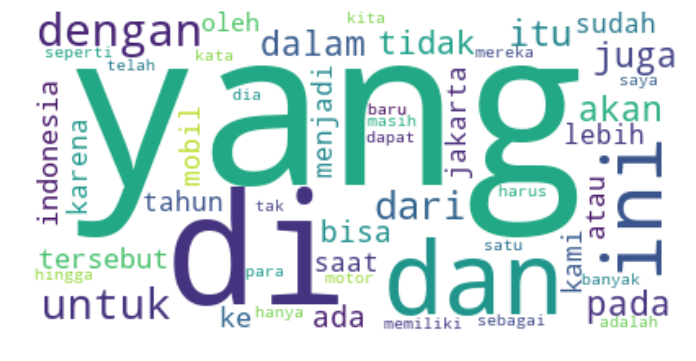

In [44]:
plt.figure(figsize=(20,6))
cloud.generate_from_frequencies(dict_uni)
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
# plt.savefig("foo.png")
plt.show()

### Freq Word in Every Category (tokenized all row)

In [6]:
list_corpus2 = df.groupby('category').agg({'content':lambda x: ' '.join(x)})

In [7]:
len(list_corpus2)

101

In [68]:
list_corpus2.tail()

content  \
category                                                        
superskor   TRIBUNNEWS.COM -Manajemen PT Persib Bandung Be...   
techno      TRIBUNNEWS.COM –‘Serba baru’ nyatanya menjadi ...   
tekno       KOMPAS.com -Ada kalanya jaringan seluler Anda ...   
travel      detikTravel Community- Taman Nasional Tanjung ...   
tribunners  Selengkapnya TRIBUNNERS- Proses penegakan huku...   

                                                       tokens  \
category                                                        
superskor   [tribunnews.com, -manajemen, pt, persib, bandu...   
techno      [tribunnews.com, –, ‘, serba, baru, ’, nyatany...   
tekno       [kompas.com, -ada, kalanya, jaringan, seluler,...   
travel      [detiktravel, community-, taman, nasional, tan...   
tribunners  [selengkapnya, tribunners-, proses, penegakan,...   

                                                   freq_alpha  \
category                                                        
superskor   {'pt': 4, 'persib': 30, 'bandung': 30, 'bermar...   
techno      {'serba': 2, 'baru': 11, 'nyatanya': 1, 'menja...   
tekno       {'kalanya': 1, 'jaringan': 4, 'seluler': 5, 'a...   
travel      {'detiktravel': 865, 'taman': 620, 'nasional':...   
tribunners  {'selengkapnya': 1, 'proses': 6, 'penegakan': ...   

                                               5_common_alpha  \
category                                                        
superskor   [(di, 154), (yang, 109), (ini, 90), (akan, 86)...   
techno      [(yang, 22), (ini, 12), (baru, 11), (dan, 10),...   
tekno       [(di, 17), (dari, 14), (yang, 13), (selfitis, ...   
travel      [(yang, 11044), (di, 9565), (dan, 6390), (ini,...   
tribunners  [(dan, 37), (narkotika, 37), (undang, 34), (pe...   

                                                   freq_digit  \
category                                                        
superskor   {'2018': 11, '1': 35, '16': 4, '30': 17, '15':...   
techno                           {'4': 1, '26': 1, '2018': 2}   
tekno       {'2014': 1, '225': 1, '20': 1, '34': 1, '42': ...   
travel      {'1971': 2, '1': 197, '2016': 13, '30': 99, '1...   
tribunners  {'1961': 2, '8': 3, '1976': 4, '1997': 1, '35'...   

                                               5_common_digit  \
category                                                        
superskor   [(1, 35), (2, 19), (30, 17), (0, 16), (2018, 1...   
techno                           [(2018, 2), (4, 1), (26, 1)]   
tekno       [(30, 2), (2014, 1), (225, 1), (20, 1), (34, 1...   
travel      [(2, 225), (1, 197), (3, 190), (5, 118), (10, ...   
tribunners  [(1976, 4), (8, 3), (35, 3), (2009, 3), (1961,...   

                                                     freq_sym  \
category                                                        
superskor   {'tribunnews.com': 23, '-manajemen': 1, '(': 1...   
techno      {'tribunnews.com': 1, '–': 1, '‘': 4, '’': 4, ...   
tekno       {'kompas.com': 3, '-ada': 1, 'whatsapp.barangk...   
travel      {'community-': 635, ''rumahnya': 1, ''': 157, ...   
tribunners  {'tribunners-': 2, ',': 47, '.ini': 1, 'penjar...   

                                                 5_common_sym  
category                                                       
superskor   [(,, 587), ((, 133), (), 133), (., 127), (:, 6...  
techno      [(,, 26), (., 11), (‘, 4), (’, 4), (!, 3), (im...  
tekno       [(,, 60), (“, 20), (”, 20), (., 16), (:, 12), ...  
travel      [(., 16958), (,, 14609), (community-, 635), ((...  
tribunners  [(,, 47), (., 13), (``, 8), ('', 8), ((, 7), (...

In [11]:
list_corpus2['tokens'] = list_corpus2['content'].apply(lambda x: nltk.word_tokenize(str(x).lower()))

In [17]:
list_corpus2['freq_alpha'] = list_corpus2['tokens'].apply(lambda x: nltk.FreqDist(ch for ch in x if ch.isalpha()))

In [69]:
list_corpus2['10_common_alpha'] = list_corpus2['freq_alpha'].apply(lambda x: x.most_common(10))

In [49]:
list_corpus2['freq_digit'] = list_corpus2['tokens'].apply(lambda x: nltk.FreqDist(ch for ch in x if ch.isdigit()))

In [70]:
list_corpus2['10_common_digit'] = list_corpus2['freq_digit'].apply(lambda x: x.most_common(10))

In [65]:
list_corpus2['freq_sym'] = list_corpus2['tokens'].apply(lambda x: nltk.FreqDist(ch for ch in x if (not ch.isalpha()) & (not ch.isdigit())))

In [71]:
list_corpus2['10_common_sym'] = list_corpus2['freq_sym'].apply(lambda x: x.most_common(10))

In [120]:
df['category'].isnull().sum()

7

In [20]:
df['category'] = df['category'].fillna('')

In [21]:
df['category'] = df['category'].apply(lambda x: x.lower())

In [22]:
df['category'].nunique()

86

In [23]:
# pd.DataFrame(df['category'].unique()).sort_values(by=0, ascending=True)[59:]

In [125]:
df['category'].nunique()

86

In [25]:
plot = pd.DataFrame(df.groupby('category')['id'].count()).sort_values(by='id', ascending=False).reset_index()

In [26]:
plot['percent'] = round((100*plot['id']/len(df)),2)

In [29]:
plot2 = plot[:10]
plot2

category     id  percent
0   otomotif  90150    37.27
1       news  67446    27.89
2   properti  11054     4.57
3       bola   8925     3.69
4   nasional   5147     2.13
5  lifestyle   4320     1.79
6     bisnis   4052     1.68
7      metro   3554     1.47
8       food   3338     1.38
9    economy   3175     1.31

In [74]:
import seaborn as sns

[Text(0,0.5,'Count'), Text(0.5,1,'Sum Count by hour')]

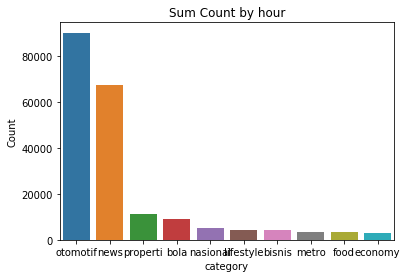

In [80]:
# hourAggregated = pd.DataFrame(train.groupby("hour")["count"].sum()).reset_index()
# hourSorted = hourAggregated.sort_values(by="hour")

ax = sns.barplot(data=plot2,x="category",y="id")
ax.set(ylabel="Count", title="Sum Count by hour")

In [120]:
df['clean_category'] = df[['category', 'subcategory', 'source']].apply(translate_category, axis=1)

In [121]:
df['clean_category'].unique()

array(['properti', 'otomotif', 'ekonomi', 'berita', 'olahraga', 'hiburan',
       'gaya hidup', 'makanan', 'teknologi', 'event', 'opini',
       'lain-lain', None, 'pendidikan'], dtype=object)

In [146]:
# df.loc[df.pubdate == '0001-02-16 00:00:00', ['pubdate']] = '2018-02-16 00:00:00'

In [147]:
# df.loc[df.pubdate == '0001-01-06 00:00:00', ['pubdate']] = '2018-01-16 00:00:00'

In [121]:
df['pubdate'] = df['pubdate'].astype('datetime64')

C:\Users\petron059243\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\internals.py:3462: FutureWarning: Passing in 'datetime64' dtype with no frequency is deprecated and will raise in a future version. Please pass in 'datetime64[ns]' instead.
  return self.apply('astype', dtype=dtype, **kwargs)


In [134]:
df.dtypes

id                         int64
post_id                    int64
author                    object
pubdate           datetime64[ns]
category                  object
subcategory               object
content                   object
comments                   int64
images                    object
title                     object
tags                      object
url                       object
source                    object
is_popular                 int64
clean_category            object
dtype: object

In [148]:
df['pubdate'] = pd.to_datetime(df['pubdate'], format='%Y-%m-%d %H:%M:%S')

In [149]:
df['time'] = df['pubdate'].dt.time

In [150]:
def class_time(time):
    if (time >= datetime.time(hour=0)) and (time <= datetime.time(hour=5)):
        return 'dini hari'
    elif (time > datetime.time(hour=5)) and (time <= datetime.time(hour=12)):
        return 'pagi hari'
    elif (time > datetime.time(hour=12)) and (time <= datetime.time(hour=18)):
        return 'sore hari'
    elif (time > datetime.time(hour=18)) and (time <= datetime.time(hour=23, minute=59, second=59)):
        return 'malam hari'
    else:
        return 'undefined'

In [151]:
df['pubdate'].dtypes

dtype('<M8[ns]')

In [152]:
df['class_time'] = df['time'].apply(lambda x : class_time(x))

In [162]:
p = pd.DataFrame(df.groupby(['class_time','clean_category'])['id'].count()).sort_values(by='id', ascending=False).reset_index()
p['percen'] = round((100*p['id']/len(df)),2)

In [165]:
p_plot = p[:10]
p_plot

class_time clean_category     id  percen
0   sore hari         berita  34227   14.15
1   sore hari       otomotif  31469   13.01
2   pagi hari       otomotif  30188   12.48
3  malam hari         berita  24042    9.94
4   pagi hari         berita  23259    9.62
5   dini hari         berita  16502    6.82
6  malam hari       otomotif  12354    5.11
7   dini hari       properti   7618    3.15
8   sore hari        ekonomi   6390    2.64
9   sore hari       olahraga   5044    2.09

In [201]:
df_dini = df[df['class_time']=='dini hari']
pdini = pd.DataFrame(df_dini.groupby('clean_category')['id'].count()).sort_values(by='id', ascending=False).reset_index()
pdini['percen'] = round((100*pdini['id']/len(df_dini)),2)
plotdini = pdini.iloc[:5]
plotdini

clean_category     id  percen
0         berita  16502   50.19
1       properti   7618   23.17
2       otomotif   4596   13.98
3       olahraga   2031    6.18
4        ekonomi    862    2.62

In [202]:
df_pagi = df[df['class_time']=='pagi hari']
ppagi = pd.DataFrame(df_pagi.groupby('clean_category')['id'].count()).sort_values(by='id', ascending=False).reset_index()
ppagi['percen'] = round((100*ppagi['id']/len(df_pagi)),2)
plotpagi = ppagi.iloc[:5]
plotpagi

clean_category     id  percen
0       otomotif  30188   42.33
1         berita  23259   32.61
2        ekonomi   4306    6.04
3       olahraga   4215    5.91
4        hiburan   2575    3.61

In [204]:
df_sore = df[df['class_time']=='sore hari']
psore = pd.DataFrame(df_sore.groupby('clean_category')['id'].count()).sort_values(by='id', ascending=False).reset_index()
psore['percen'] = round((100*psore['id']/len(df_sore)),2)
plotsore = psore.iloc[:5]
plotsore

clean_category     id  percen
0         berita  34227   38.80
1       otomotif  31469   35.68
2        ekonomi   6390    7.24
3       olahraga   5044    5.72
4        hiburan   3391    3.84

In [205]:
df_malam = df[df['class_time']=='malam hari']
pmalam = pd.DataFrame(df_malam.groupby('clean_category')['id'].count()).sort_values(by='id', ascending=False).reset_index()
pmalam['percen'] = round((100*pmalam['id']/len(df_malam)),2)
plotmalam = pmalam.iloc[:5]
plotmalam

clean_category     id  percen
0         berita  24042   48.60
1       otomotif  12354   24.98
2       olahraga   4032    8.15
3        ekonomi   3528    7.13
4        hiburan   1524    3.08

In [166]:
cat_gen = pd.DataFrame(df.groupby('clean_category')['id'].count()).sort_values(by='id', ascending=False)

In [168]:
cat_gen['percen'] = round((100*cat_gen['id']/len(df)),2)

In [169]:
cat_gen

id  percen
clean_category               
berita          98030   40.53
otomotif        78607   32.50
olahraga        15322    6.33
ekonomi         15086    6.24
properti        11409    4.72
hiburan          7934    3.28
makanan          5923    2.45
teknologi        4553    1.88
gaya hidup       4391    1.82
opini              77    0.03
pendidikan         45    0.02
lain-lain          26    0.01
event               8    0.00

In [248]:
df['source'] = df['source'].apply(lambda x: str(x).lower())

In [249]:
df['source'].nunique()

29

In [30]:
# df.groupby(['author', 'source']).count()[['id']].sort_values(by=['id'], ascending=False)

In [154]:
df['class_time'].unique()

array(['pagi hari', 'dini hari', 'sore hari', 'malam hari'], dtype=object)

In [36]:
# src = pd.DataFrame(df.groupby('source')['id'].count())
# src['percen'] = round((100*src['id']/len(df)),2)
# src

In [37]:
df['category'].nunique()

86

In [13]:
def translate_category(x):
	"""
	Function for otomotif and property category mapping
	"""
	x[0] = str(x[0])
	x[1] = str(x[1])
	x[2] = str(x[2])

	if ('seva' in x[2].lower()) and ('properti' not in x[0].lower()):
		return 'otomotif'
	elif x[0].lower() in ["oto", "otomotif", "mobil", "modifikasi"]:
		return 'otomotif'
	elif (x[0].lower() in ["autotekno"]) and (x[1].lower() in ['mobil', 'motor', 'advertorial autotekno', 'komunitas', 'modifikasi', 'rest area', 'test', 'tips & trik']):
		return 'otomotif'
	elif (x[0].lower() in ["home"]) and (x[1].lower() in ['otomotif']):
		return 'otomotif'
	elif (x[0].lower() in ["home"]) and (x[1].lower() in ['properti']):
		return 'properti'
	elif (x[0].lower() in ['bisnis', 'properti', 'finance', 'ekbis', 'ekonomi', 'economy']) and ('properti' in x[1].lower()):
		return 'properti'
	else:
		return x[0].lower()

In [15]:
df['clean_category'] = df[['category', 'subcategory', 'source']].apply(translate_category, axis=1)

In [16]:
df.head()

id  post_id         author              pubdate  category  \
0   1      271          Ferdi  2018-07-26 09:57:15  properti   
1   2      261          Ferdi  2018-07-18 08:31:17  properti   
2   3      253          Ferdi  2018-07-17 11:42:13  properti   
3   4      221  Arris Riehady  2018-07-11 09:55:45  properti   
4   5      165          Ferdi  2018-03-07 11:23:54  properti   

          subcategory                                            content  \
0  tips-n-rekomendasi  Membeli hunian atau tempat tinggal yang tepat ...   
1  tips-n-rekomendasi  “Membeli rumah tidak seperti membeli kacang go...   
2  tips-n-rekomendasi  Properti merupakan salah satu aset yang mengun...   
3  tips-n-rekomendasi  Memiliki rumah yang lapang tentunya jadi idama...   
4  tips-n-rekomendasi  Investasi kini sudah menjadi salah satu bagian...   

   comments                                             images  \
0         0  https://www.seva.id/properti/wp-content/upload...   
1         0  https://www.seva.id/properti/wp-content/upload...   
2         0  https://www.seva.id/properti/wp-content/upload...   
3         0  https://www.seva.id/properti/wp-content/upload...   
4         0  https://www.seva.id/properti/wp-content/upload...   

                                               title  \
0  Rumah vs Apartemen, Mana yang Cocok untuk Pasa...   
1  Ingin Beli Rumah? Pahami Metode Pembayaranya Dulu   
2  5 Ciri Investasi Properti yang Tidak Menguntun...   
3           6 Trik Agar Rumah Mungil Terlihat Lapang   
4  Alasan Kenapa Investasi Properti Dinilai Lebih...   

                                                tags  \
0  alasan pilih apartemen,alasan pilih rumah,pili...   
1  cara beli properti,cara beli rumah,transaksi b...   
2   ciri investasi merugikan,investasi properti rugi   
3  siasati ruangan sempit,tips rumah kecil,tips r...   
4  investasi di properti,investasi yang menguntun...   

                                                 url source  is_popular  \
0  https://www.seva.id/properti/blog/rumah-vs-apa...   seva           0   
1  https://www.seva.id/properti/blog/ingin-beli-r...   seva           0   
2  https://www.seva.id/properti/blog/5-ciri-inves...   seva           0   
3  https://www.seva.id/properti/blog/6-trik-agar-...   seva           0   
4  https://www.seva.id/properti/blog/alasan-kenap...   seva           0   

  clean_category  
0       properti  
1       properti  
2       properti  
3       properti  
4       properti

In [19]:
author_oto = df[(df['clean_category'].str.contains('otomotif')) | (df['category'].str.contains('otomotif')) | (df['subcategory'].str.contains('otomotif'))] 

In [20]:
oto = pd.DataFrame(author_oto.groupby(['author','source']).count()[['id']]).sort_values(by='id', ascending=False).reset_index().iloc[:5]
oto

author     source    id
0        Adi Hidayat   mobil123  3844
1  Danu P Dirgantoro  otodriver  3010
2   Fitradian Dhimas     otosia  2832
3    Aldiro Syahrian  rajamobil  2385
4   Fajar Ardiansyah     otosia  2263

In [23]:
author_prop = df[(df['clean_category'].str.contains('properti')) | (df['category'].str.contains('properti')) | (df['subcategory'].str.contains('properti'))] 

In [286]:
author_oto['clean_category'] = author_oto['clean_category'].fillna('otomotif')

C:\Users\petron059243\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [287]:
author_oto['clean_category'].isnull().sum()

0

In [180]:
author_oto['source'].unique()

array(['seva', 'gridoto', 'otodriver', 'cintamobil', 'rajamobil',
       'otorider', 'tempo', 'carmudi', 'detik', 'carreview', 'mobil123',
       'oto', 'otosia', 'Sindonews', 'Liputan6', 'metrotvnews',
       'otomart.com', 'tirto.id', 'kompas'], dtype=object)

In [240]:
author_prop =  df3[(df3['clean_category'] == 'properti') | (df3['category'] == 'properti') | (df3['subcategory'] == 'properti')]

In [276]:
# author_prop[author_prop['clean_category'].isnull()]

In [22]:
author_prop['clean_category'] = author_prop['clean_category'].fillna('properti')

C:\Users\stezar059244\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [24]:
prop = pd.DataFrame(author_prop.groupby(['author','source']).count()[['id']]).sort_values(by='id', ascending=False).reset_index().iloc[:6]
prop

author           source   id
0    Anto Erawan       rumahhokie  970
1  Adhitya Putra       rumahhokie  655
2           Dody          rumahku  606
3            Dea          rumahku  444
4          Padre  propertiterkini  320
5          Yudis    housingestate  305

In [242]:
author_prop['source'].unique()

array(['seva', 'tempo', 'rumah123', 'housingestate', 'detik',
       'rumahhokie', 'Sindonews', 'Liputan6', 'propertiterkini', 'kompas',
       'rumahku'], dtype=object)

In [259]:
len(df)

241868

In [169]:
com = df[df['comments'] != 0]
pop = df[df['is_popular'] != 0]

In [258]:
len(df[df['source'] == 'liputan6']) + len(df[df['source'] == 'otomart.com']) 

15285

In [255]:
in_com =df[(df['source'] == 'liputan6') | (df['source'] == 'otomart.com')]
len(in_com)

15285

In [250]:
# com[com['source']=='otomart.com']

In [ ]:
len

In [175]:
round((100 * len(com)/len(df)),2)

1.29

In [170]:
com['source'].unique()

array(['Liputan6', 'otomart.com'], dtype=object)

In [171]:
pop['source'].unique()

array([], dtype=object)

In [239]:
plot1 = pd.DataFrame(author_oto.groupby('class_time').count()[['id']])
plot1
plot1['percen'] = round((100*plot1['id']/(len(author_oto)+len(author_prop))),2)
# plotdini = pdini.iloc[:5]
plot1

id  percen
class_time               
dini hari    2264    2.27
malam hari  15013   15.06
pagi hari   33984   34.09
sore hari   37024   37.14

In [228]:
plot1 = pd.DataFrame(author_prop.groupby('class_time').count()[['id']])
plot1['percen'] = round((100*plot1['id']/(len(author_oto)+len(author_prop))),2)
plot1

id  percen
class_time              
dini hari   7616    7.64
malam hari   902    0.90
pagi hari   1803    1.81
sore hari   1089    1.09

In [201]:
len(author_oto)+len(author_prop)

102140

In [200]:
len(author_prop)

11412

In [209]:
df3 = df[df['time'] != datetime.time(hour=0)]

In [220]:
df3.head()

id  post_id         author             pubdate  category  \
0   1      271          ferdi 2018-07-26 09:57:15  properti   
1   2      261          ferdi 2018-07-18 08:31:17  properti   
2   3      253          ferdi 2018-07-17 11:42:13  properti   
3   4      221  arris riehady 2018-07-11 09:55:45  properti   
4   5      165          ferdi 2018-03-07 11:23:54  properti   

          subcategory                                            content  \
0  tips-n-rekomendasi  Membeli hunian atau tempat tinggal yang tepat ...   
1  tips-n-rekomendasi  “Membeli rumah tidak seperti membeli kacang go...   
2  tips-n-rekomendasi  Properti merupakan salah satu aset yang mengun...   
3  tips-n-rekomendasi  Memiliki rumah yang lapang tentunya jadi idama...   
4  tips-n-rekomendasi  Investasi kini sudah menjadi salah satu bagian...   

   comments                                             images  \
0         0  https://www.seva.id/properti/wp-content/upload...   
1         0  https://www.seva.id/properti/wp-content/upload...   
2         0  https://www.seva.id/properti/wp-content/upload...   
3         0  https://www.seva.id/properti/wp-content/upload...   
4         0  https://www.seva.id/properti/wp-content/upload...   

                                               title  \
0  Rumah vs Apartemen, Mana yang Cocok untuk Pasa...   
1  Ingin Beli Rumah? Pahami Metode Pembayaranya Dulu   
2  5 Ciri Investasi Properti yang Tidak Menguntun...   
3           6 Trik Agar Rumah Mungil Terlihat Lapang   
4  Alasan Kenapa Investasi Properti Dinilai Lebih...   

                                                tags  \
0  alasan pilih apartemen,alasan pilih rumah,pili...   
1  cara beli properti,cara beli rumah,transaksi b...   
2   ciri investasi merugikan,investasi properti rugi   
3  siasati ruangan sempit,tips rumah kecil,tips r...   
4  investasi di properti,investasi yang menguntun...   

                                                 url source  is_popular  \
0  https://www.seva.id/properti/blog/rumah-vs-apa...   seva           0   
1  https://www.seva.id/properti/blog/ingin-beli-r...   seva           0   
2  https://www.seva.id/properti/blog/5-ciri-inves...   seva           0   
3  https://www.seva.id/properti/blog/6-trik-agar-...   seva           0   
4  https://www.seva.id/properti/blog/alasan-kenap...   seva           0   

  clean_category      time class_time  
0           None  09:57:15  pagi hari  
1           None  08:31:17  pagi hari  
2           None  11:42:13  pagi hari  
3           None  09:55:45  pagi hari  
4           None  11:23:54  pagi hari

In [236]:
df3 = df[df['time'] != datetime.time(hour=0, minute=0, second=0)]

In [238]:
df3.shape

(226608, 17)

In [265]:
pagi = df3[df3['class_time'] == 'pagi hari']
sore = df3[df3['class_time'] == 'sore hari']
malam = df3[df3['class_time'] == 'malam hari']
dini = df3[df3['class_time'] == 'dini hari']

In [264]:
pagi.groupby('author').count()[['id']].sort_values(by='id',ascending=False).head(5)

id
author                 
danu p dirgantoro  2054
adi hidayat        1875
aldiro syahrian    1577
unggul tri ratomo  1342
hariawan arif      1261

In [266]:
sore.groupby('author').count()[['id']].sort_values(by='id',ascending=False).head(5)

id
author               
adi hidayat      1600
jafar m sidik    1436
fitri supratiwi  1256
aldiro syahrian  1180
syubhan akib     1175

In [267]:
malam.groupby('author').count()[['id']].sort_values(by='id',ascending=False).head(5)

id
author                
ruslan burhani    3396
tasrief tarmizi   2050
kunto wibisono    1951
suryanto          1444
fitradian dhimas   949

In [268]:
dini.groupby('author').count()[['id']].sort_values(by='id',ascending=False).head(5)

id
author                
nan               7577
ruslan burhani     409
suryanto           409
kunto wibisono     376
gilang galiartha   322

In [289]:
df5 = pd.concat([author_oto,author_prop],1)

In [290]:
df5.shape

(99695, 34)

In [292]:
author_oto.shape

(88285, 17)

In [293]:
author_prop.shape

(11410, 17)

In [3]:
# author_oto.groupby('class_time')

In [6]:
a = df[df['source'] == 'tirto.id']
a[a['title'] == 'Partai Politik dalam Belantara Media Sosial']

Empty DataFrame
Columns: [id, post_id, author, pubdate, category, subcategory, content, comments, images, title, tags, url, source, is_popular]
Index: []

In [8]:
author = df.groupby(['author']).count()[['id']].sort_values(by='id',ascending=False).head(5)

In [9]:
author

id
author               
Ruslan Burhani   5955
Kunto Wibisono   4199
Suryanto         3891
Adi Hidayat      3844
Tasrief Tarmizi  3520